# Neural Network 

## 1. Imports

In [20]:
import HelperFunctions as hf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

## 2. Fetching and preparing data

In [21]:
#Load in the raw data
calendar_df = hf.load_calendar_data()
prices_df = hf.load_sell_price_data()
sales_df = hf.load_sales_train_validation_data()

In [22]:
#Clean the raw data
num = 1300
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=num, items=100, dropNAPrices=True)

In [23]:
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days
# df = hf.rollingMeanDemandFeature(df, windowSize=365, shift=1) 

df = hf.rollingStdDemandFeature(df, windowSize=7, shift=1)
df = hf.rollingStdDemandFeature(df, windowSize=28, shift=1)
# df = hf.rollingStdDemandFeature(df, windowSize=365, shift=1)

In [24]:
df = hf.rollingMeanWeekday(df, weeks = 4, shift = 1) #mean of previous 3 weeks (for that particular weekday)
df = hf.rollingMeanWeekday(df, weeks = 8, shift = 1) #mean of previous 3 weeks (for that particular weekday)
# df = hf.rollingMeanWeekday(df, weeks = 52, shift = 1) #mean of previous 3 weeks (for that particular weekday)

In [25]:
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before
# df = hf.lagFeature(df, var='sold', lag=365) #Amount sold 28 days before

In [26]:
df = hf.priceDifference(df)
df = hf.rollingPriceDifference(df, windowsize=7)

In [27]:
df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [28]:
#Standardise features
cols_to_norm = ['d','wday','month','year','sell_price',  'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_std_7_1', 'rolling_std_28_1',
       'rolling_mean_4_1', 'rolling_mean_8_1',
       'sold_lag_1', 'sold_lag_7', 'sold_lag_28',
       'price_diff']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [29]:
df.describe()

,d,wday,month,year,sell_price,rolling_mean_7_1,rolling_mean_28_1,rolling_std_7_1,rolling_std_28_1,rolling_mean_4_1,rolling_mean_8_1,sold_lag_1,sold_lag_7,sold_lag_28,price_diff,price_increase,price_decrease,price_increase_7,price_decrease_7
count,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,8.535000e+04,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000,85350.000000
mean,0.562401,0.498231,0.491249,0.540488,0.211879,0.023420,0.031607,3.459193e-02,0.054469,0.023541,0.026691,0.013836,0.013857,0.013891,0.500011,0.001265,0.000961,0.008647,0.006772
std,0.277912,0.333735,0.297400,0.340928,0.172952,0.060928,0.079465,5.438348e-02,0.078141,0.061402,0.067845,0.040350,0.040505,0.040641,0.007617,0.035550,0.030981,0.092586,0.082014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.334382,0.166667,0.272727,0.333333,0.081656,0.000000,0.003226,1.659428e-09,0.017554,0.000000,0.002375,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,0.583006,0.500000,0.454545,0.666667,0.176538,0.007177,0.011290,2.430126e-02,0.035677,0.008403,0.009501,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
75%,0.805665,0.833333,0.727273,0.666667,0.290972,0.021531,0.028226,4.150230e-02,0.064051,0.021008,0.023753,0.009901,0.009901,0.009901,0.500000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_std_7_1', 'rolling_std_28_1', 'rolling_mean_4_1',
       'rolling_mean_8_1', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28',
       'price_diff', 'price_increase', 'price_decrease', 'price_increase_7',
       'price_decrease_7'],
      dtype='object')

In [31]:

df_item = df.loc[df.id == "FOODS_2_360_TX_3_validation"]
df_test = df.loc[df.d > 1200/num]
df = df.loc[df.d <= 1200/num]

In [14]:
df.shape, df_test.shape, df_item.shape

((758905, 56), (89515, 56), (1244, 56))

In [15]:
df.columns

Index(['id', 'd', 'sold', 'wday', 'month', 'year', 'snap_CA', 'snap_TX',
       'snap_WI', 'sell_price', 'Cultural', 'National', 'Religious',
       'Sporting', 'NoEvent', 'Christmas', 'weekend', 'midweek', 'monfri',
       'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2',
       'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS', 'HOBBIES', 'HOUSEHOLD', 'CA_1',
       'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3',
       'CA', 'TX', 'WI', 'rolling_mean_7_1', 'rolling_mean_28_1',
       'rolling_std_7_1', 'rolling_std_28_1', 'rolling_mean_4_1',
       'rolling_mean_8_1', 'sold_lag_1', 'sold_lag_7', 'sold_lag_28',
       'price_diff', 'price_increase', 'price_decrease', 'price_increase_7',
       'price_decrease_7'],
      dtype='object')

In [16]:
len(set(df_test.d))

98

## Means

In [187]:
df["sold"] = df["sold"].astype(float)

In [188]:
df_means = df.groupby("id", as_index = False).mean()

In [190]:
preds = []
for index, row in df.iterrows():
    preds.append(df_means.loc[df_means.id == row.id].sold)

In [ ]:
mean_squared_error(preds, df.sold.values)

### Setting up 

In [17]:
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [18]:

y = df.pop("sold")
y = y.values
y = y.astype(float)


In [19]:
df = df.astype(float)

## feature selection

In [199]:

remove = True
while remove == True:
    mod = sm.OLS(y, df)
    res = mod.fit()
    pval = pd.DataFrame(res.pvalues)
    if len(pval.loc[pval[0] > 0.05]) == 0:
        remove = False
    else:
        worst_col = pval.loc[pval[0] > 0.05].T.columns[pval.loc[pval[0] > 0.05][0].argmax()]
        print(worst_col , pval.loc[pval[0] > 0.05].max()[0])
        df = df.drop([worst_col], axis = 1)
        df_test = df_test.drop([worst_col], axis = 1)
        
    

Religious 0.9795828745939195
NoEvent 0.8740215056190022
weekend 0.8342523344409017
FOODS_3 0.7861870536407058
CA_2 0.7818621842234851
WI_1 0.7196380847658042
HOUSEHOLD_1 0.7150982858087367
HOBBIES_1 0.710968554063756
CA 0.7008901794658124
TX_2 0.9864281063786154
FOODS 0.6989656191463778
TX_3 0.6868360337575533
WI_2 0.6870651959003944
Sporting 0.6212678232968412
sold_lag_7 0.5850061096429136
TX_1 0.5168490573674498
HOUSEHOLD 0.5051997533920446
CA_3 0.31977722286007704
WI 0.4518031991324901
CA_4 0.4545131333356883
CA_1 0.5335421395914204
HOBBIES 0.287956850023127
TX 0.24923180200879758
year 0.22952722066904654
month 0.96605394489204
d 0.42991783857515975
WI_3 0.19118258577984615
FOODS_1 0.05882961820248451
HOUSEHOLD_2 0.06945695448088542
HOBBIES_2 0.09494922280405116


In [200]:
df.columns

Index(['wday', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'Cultural',
       'National', 'Christmas', 'midweek', 'monfri', 'FOODS_2',
       'rolling_mean_7_1', 'rolling_mean_28_1', 'rolling_mean_365_1',
       'rolling_std_7_1', 'rolling_std_28_1', 'rolling_std_365_1',
       'rolling_mean_4_1', 'rolling_mean_8_1', 'rolling_mean_52_1',
       'sold_lag_1', 'sold_lag_28', 'sold_lag_365', 'price_diff',
       'price_increase', 'price_decrease', 'price_increase_7',
       'price_decrease_7'],
      dtype='object')

In [20]:

X = df.values


In [21]:
X.shape

(758905, 54)

## 3. Setting up loaders

In [22]:
X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [23]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
X_train.shape, y_train.shape

(torch.Size([607124, 54]), torch.Size([607124]))

In [25]:
# create data loaders

from torch.utils import data

traindataset = data.TensorDataset(X_train, y_train) # create your datset
trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


testdataset = data.TensorDataset(X_test,y_test) # create your datset
testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader



## 4. Building neural net

In [26]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, 1)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        
        return out

In [27]:
from torchbearer import Trial
import torchbearer
from sklearn.metrics import mean_squared_error

In [28]:
# build the model 
model = BaselineModel(X_train.shape[1], 512)

# define the loss function and the optimiser
loss_function = nn.MSELoss()
optimiser = optim.Adam(model.parameters())

loss_plot = []
loss_eval = []
# the epoch loop
for epoch in range(20):
    running_loss = 0.0

    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    loss_plot.append(running_loss/len(trainloader))
    
    model.eval()
    mse = 0
    for index, i in enumerate(testloader):

        inputs, labels = i
          
        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        mse += mean_squared_error(labels, outputs)
    loss_eval.append(mse/len(testloader))
    
    
    print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
print('**** Finished Training ****')


Epoch 0, loss 7.29, test loss 6.48


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_plot, label = "Training")
plt.plot(loss_eval, label = "Testing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

## Testing Model 1200-1300

In [40]:
def prepare(df):
    df= df.drop("id", axis = 1)
    y = df.pop("sold")
    y =  torch.FloatTensor(y.values.astype(float))
    return(df, y)

In [41]:
df_test, y_test= prepare(df_test)

In [42]:
def evaluate(model, df, y):
    model.eval()

    preds = []
    for index, i in enumerate( torch.FloatTensor(df.values.astype(float))):
        inputs = i
        label = y[index]

        outputs = model(inputs)
        outputs = outputs.detach().numpy()
        preds.append(outputs)
    preds = np.asarray(preds)
    preds.shape = (preds.shape[0],)
    return(preds)

In [43]:
preds_test = evaluate(model, df_test, y_test)

In [44]:
mean_squared_error(preds_test, y_test)

3.6230893

## Means

In [45]:
preds = []
for index, row in df_test.iterrows():
    preds.append(df_means.loc[df_means.id == row.id].sold)

AttributeError: 'Series' object has no attribute 'id'

In [ ]:
mean_squared_error(preds, y_test)

## Department 

In [ ]:
def depMSE(col):
    df_dep = df[(df[col] == 1)]
    df_dep, y_dep = prepare(df_dep)
    preds_dep = evaluate(model, df_dep, y_dep)
    return(mean_squared_error(preds_dep, y_dep))

In [ ]:
depMSE("FOODS")

In [ ]:
depMSE("HOUSEHOLD")

In [ ]:
depMSE("HOBBIES")

## Department Length STD and Mean

In [ ]:
[len(df[(df[i] == 1)]) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

In [109]:
[round((df.sold[(df[i] == 1)]).values.mean(), 2) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

[2.22, 0.83, 0.33]

In [110]:
[round((df.sold[(df[i] == 1)]).values.std(), 2) for i in ["FOODS", "HOUSEHOLD", "HOBBIES"]]

[5.51, 1.64, 0.79]

## MSE BY STATE

In [116]:
depMSE("TX"), depMSE("CA"), depMSE("WI")

(8.450689, 4.255197, 1.2261016)

In [117]:
[len(df[(df[i] == 1)]) for i in ["TX", "CA", "WI"]]

[14815, 22819, 13616]

In [118]:
[round((df.sold[(df[i] == 1)]).values.mean(), 2) for i in ["TX", "CA", "WI"]]

[2.16, 1.51, 0.6]

In [119]:
[round((df.sold[(df[i] == 1)]).values.std(), 2) for i in ["TX", "CA", "WI"]]

[6.45, 3.14, 1.28]

## TESTING FOODS_2_360_TX_3 predictions.xlsx

In [34]:
df_item = df_item.drop("id", axis = 1)

In [35]:
y_item = df_item.pop("sold")

In [36]:
y_item =  torch.FloatTensor(y_item.values.astype(float))

In [49]:
model.eval()

preds = []
for index, i in enumerate( torch.FloatTensor(df_item.values[-100:].astype(float))):
    inputs = i
    label = y_item[index]

    outputs = model(inputs)
    outputs = outputs.detach().numpy()
    preds.append(outputs)


In [50]:
len(preds)

100

In [51]:
m = np.asarray([df_means.loc[df_means.id == "FOODS_2_360_TX_3_validation"].sold.values] * 100)

In [52]:
m.shape = (100,)

In [66]:
preds = pd.read_excel("FOODS_2_360_TX_3 predictions.xlsx",  engine='openpyxl').values[:, :-3]

# preds.shape = (100,)

In [67]:
preds.shape

(4, 98)

In [68]:
len(set(df_item.d))

1242

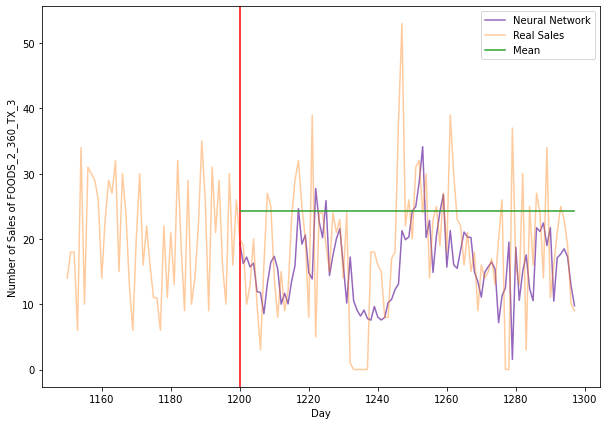

In [78]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
plt.plot([i for i in range(1200, 1298)], preds[2], label = "Neural Network", c = "C4")
#plt.plot([i for i in range(1200, 1298)], preds[3], label = "Linear Regression", c = "C3")
#plt.plot([i for i in range(1200, 1298)], preds[1], label = "SVR", c = "C0")
plt.plot([i for i in range(1150, 1298)], y_item[-148:], label = "Real Sales", c = "C1", linestyle="-", alpha = 0.4)
plt.axvline(1200, c = "r")
plt.plot([i for i in range(1200, 1298)],preds[0], label = "Mean", c = "C2")
plt.xlabel("Day")
plt.ylabel("Number of Sales of FOODS_2_360_TX_3")
plt.legend()

In [211]:
preds = np.asarray(preds)

In [125]:
preds.shape = (100,)

In [134]:
df_pred = pd.DataFrame(preds).T

In [139]:
df_pred.to_excel("FOODS_2_360_TX_3 predictions.xlsx", index = False)

In [212]:
df = pd.read_excel("FOODS_2_360_TX_3 predictions.xlsx",  engine='openpyxl')

In [213]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,29.62118,20.697523,26.282949,23.723934,20.582651,20.892366,23.925562,18.570688,17.925602,15.371912,...,30.741135,24.644682,23.731657,20.104092,26.284115,23.300997,26.780066,27.07473,20.991177,15.175308


In [220]:
df_withmean = pd.concat([df, pd.DataFrame(m).T], axis = 0)

In [221]:
df_withmean.to_excel("FOODS_2_360_TX_3 predictions.xlsx", index = False)

In [35]:
# model.eval()
# plt.figure(figsize = (10,10))
# for index, i in enumerate(trainloader):
#     if index < 1:
#         inputs, labels = i
          
#         outputs = model(inputs)
#         outputs = outputs.detach().numpy()
#         plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
#         print(outputs)
#         plt.plot(outputs, label = "Predicted Sales")
#         plt.legend()
# #         plt.ylim(0, 30)
#         plt.xlim(0, 100)
#         #print(inputs, labels)
#     else:
#         break

In [36]:
# model.eval()
# plt.figure(figsize = (10,10))
# for index, i in enumerate(testloader):
#     if index < 1:
#         inputs, labels = i
          
#         outputs = model(inputs)
#         outputs = outputs.detach().numpy()
#         plt.plot([i for i in range(len(labels))], labels, label = "True Sales")
#         print(outputs)
#         plt.plot(outputs, label = "Predicted Sales")
#         plt.legend()
# #         plt.ylim(0, 30)
#         plt.xlim(0, 100)
#         #print(inputs, labels)
#     else:
#         break

In [28]:
model.eval()

mse = 0

for data in trainloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Train: ", mse/len(trainloader))

Train:  4.504484135930131


In [29]:
model.eval()

mse = 0

for data in testloader:
    inputs, labels = data
    
    outputs = model(inputs)
    
    outputs = outputs.detach().numpy()
    mse += mean_squared_error(labels, outputs)
print("Test: ", mse/len(testloader))

Test:  4.5568133050745185


## K-Fold 

In [37]:
def train_model(X_train, y_train, X_test, y_test):
        
        # create data loaders

    from torch.utils import data
    traindataset = data.TensorDataset(X_train, y_train) # create your datset
    trainloader = data.DataLoader(traindataset, batch_size=1024, shuffle=True) # create your dataloader


    testdataset = data.TensorDataset(X_test,y_test) # create your datset
    testloader = data.DataLoader(testdataset, batch_size=1024, shuffle=True) # create your dataloader


        
        
    # build the model 
    model = BaselineModel(X_train.shape[1], 512)

    # define the loss function and the optimiser
    loss_function = nn.MSELoss()
    optimiser = optim.Adam(model.parameters())

    loss_plot = []
    loss_eval = []
    # the epoch loop
    for epoch in range(20):
        running_loss = 0.0

        for data in trainloader:
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimiser.zero_grad()

            # forward + loss + backward + optimise (update weights)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = loss_function(outputs, labels)
            loss.backward()
            optimiser.step()

            # keep track of the loss this epoch
            running_loss += loss.item()
        loss_plot.append(running_loss/len(trainloader))

        model.eval()
        mse = 0
        for index, i in enumerate(testloader):

            inputs, labels = i

            outputs = model(inputs)
            outputs = outputs.detach().numpy()
            mse += mean_squared_error(labels, outputs)
        loss_eval.append(mse/len(testloader))


        print("Epoch %d, loss %4.2f, test loss %4.2f" % (epoch, running_loss/len(trainloader), mse/len(testloader)))
    print('**** Finished Training ****')

    return(loss_plot[-1], loss_eval[-1])



In [38]:
from sklearn.model_selection import KFold
from torch.utils import data
kf5 = KFold(n_splits=6, shuffle=False)
def kfold_val(X, Y):
    res= []

    for index, (train_index, test_index) in enumerate(kf5.split(range(len(X)))):
        if index < 5:
            res.append(train_model(X[train_index], Y[train_index],X[train_index], Y[train_index]))

    return(np.array(res))

In [39]:
res = kfold_val(X, y)

Epoch 0, loss 5.68, test loss 4.84
Epoch 1, loss 4.88, test loss 4.90
Epoch 2, loss 4.83, test loss 4.70
Epoch 3, loss 4.85, test loss 4.71
Epoch 4, loss 4.76, test loss 4.83
Epoch 5, loss 4.86, test loss 5.20
Epoch 6, loss 4.91, test loss 4.57
Epoch 7, loss 4.66, test loss 4.48
Epoch 8, loss 4.66, test loss 4.74
Epoch 9, loss 4.54, test loss 4.39
Epoch 10, loss 4.50, test loss 5.27
Epoch 11, loss 4.49, test loss 4.26
Epoch 12, loss 4.44, test loss 4.58
Epoch 13, loss 4.57, test loss 5.20
Epoch 14, loss 4.56, test loss 4.18
Epoch 15, loss 4.42, test loss 4.27
Epoch 16, loss 4.26, test loss 4.16
Epoch 17, loss 4.19, test loss 4.13
Epoch 18, loss 4.21, test loss 4.06
Epoch 19, loss 4.37, test loss 4.82
**** Finished Training ****
Epoch 0, loss 6.82, test loss 6.49
Epoch 1, loss 5.74, test loss 5.40
Epoch 2, loss 5.37, test loss 5.32
Epoch 3, loss 5.54, test loss 6.00
Epoch 4, loss 5.50, test loss 5.31
Epoch 5, loss 5.28, test loss 5.45
Epoch 6, loss 5.39, test loss 5.23
Epoch 7, loss 5.2

In [40]:
res

array([[4.37453762, 4.81888207],
       [4.75242199, 5.01156299],
       [4.73216215, 4.99203589],
       [4.71438932, 4.82818273],
       [4.57204967, 4.48658351]])

In [41]:
res = np.asarray(res)

In [42]:
np.mean(res[:, 0]), np.std(res[:, 0])

(4.6291121505555655, 0.14224003308188585)

In [43]:
np.mean(res[:, 1]), np.std(res[:, 1])

(4.82744943641481, 0.1882817148730687)